---
syncID: 84457ead9b964c8d916eacde9f271ec7
title: "Assessing Spectrometer Accuracy using Validation Tarps with Python"
description: "Comparison of reflectance curves collected over spectral validation tarps with ASD and NIS sensors." 
dateCreated: 2017-06-21 
authors: Tristan Goulden
contributors: Donal O'Leary, Bridget Hass
estimatedTime: 30 minutes
packagesLibraries: gdal, h5py, requests
topics: hyperspectral-remote-sensing, remote-sensing
languagesTool: python
dataProduct: 
code1: https://raw.githubusercontent.com/NEONScience/NEON-Data-Skills/main/tutorials/Python/Hyperspectral/uncertainty-and-validation/hyperspectral_validation_py/hyperspectral_validation_py.ipynb
tutorialSeries: rs-uncertainty-py-series
urlTitle: hyperspectral-validation-py
---

In this tutorial we will learn how to retrieve reflectance curves from a pre-specified coordinate in a NEON AOP HDF5 file, retrieve bad band window indexes and mask portions of a reflectance curve, plot reflectance curves, and gain an understanding of some sources of uncertainty in Neon Imaging Spectrometer (NIS) data.

<div id="ds-objectives" markdown="1">

### Objectives
After completing this tutorial, you will be able to:

* Retrieve reflectance curves from a pre-specified coordinate in a NEON AOP HDF5 file
* Retrieve bad band window indexes and mask these invalid portions of the reflectance curves
* Plot reflectance curves on a graph and save the file
* Explain some sources of uncertainty in NEON Image Spectrometry data

### Install Python Packages

* **gdal** 
* **h5py** 
* **requests**


### Download Data

To complete this tutorial, you will use data from the NEON 2017 Data Institute. You can read in and download all the required data for this lesson as follows, and as described later on.

This tutorial uses the following files:

<ul>
<li>CHEQ_Tarp_03_02_refl_bavg.txt (9 KB)</li>
<li>CHEQ_Tarp_48_01_refl_bavg.txt (9 KB)</li>
<li>NEON_D05_CHEQ_DP1_20160912_160540_reflectance.h5 (2.7 GB)</li>
</ul>

The first two files can be downloaded from: <a href="https://github.com/NEONScience/NEON-Data-Skills/tree/main/tutorials/Python/Hyperspectral/uncertainty-and-validation/hyperspectral_validation_py/data" target="_blank">NEON-Data-Skills GitHub<a/>.
    
**Download the CHEQ Reflectance File:** 

<a href="https://storage.googleapis.com/neon-aop-products/2016/FullSite/D05/2016_CHEQ_2/L1/Spectrometer/ReflectanceH5/2016091215/NEON_D05_CHEQ_DP1_20160912_160540_reflectance.h5" class="link--button link--arrow">NEON_D05_CHEQ_DP1_20160912_160540_reflectance.h5</a>
    
Note: The imagery data used to create this raster teaching data subset were collected over the 
<a href="http://www.neonscience.org/" target="_blank"> National Ecological Observatory Network</a>'s
<a href="http://www.neonscience.org/science-design/field-sites/" target="_blank" >field sites</a> and processed at NEON headquarters.
The entire dataset can be accessed on the <a href="http://data.neonscience.org" target="_blank">NEON Data Portal</a>.
    
### Recommended prerequisites

We recommend you complete the following tutorials prior to this lesson: 

1.  <a href="https://www.neonscience.org/neon-aop-hdf5-py"> *NEON AOP Hyperspectral Data in HDF5 format with Python*</a>
1.  <a href="https://www.neonscience.org/neon-hsi-aop-functions-python"> *Band Stacking, RGB & False Color Images, and Interactive Widgets in Python*</a>
1.  <a href="https://www.neonscience.org/plot-spec-sig-python/"> *Plot a Spectral Signature in Python*</a>

</div>

In this tutorial we will be examining the accuracy of the Neon Imaging Spectrometer (NIS) against targets with known reflectance values. The targets consist of two 10 x 10 m tarps which have been specially designed to have 3% reflectance (black tarp) and 
48% reflectance (white tarp) across all of the wavelengths collected by the NIS (see images below). During the Sept. 12 2016 flight over the Chequamegon-Nicolet National Forest (CHEQ), an area in D05 which is part of NEON's <a href="https://www.neonscience.org/field-sites/stei">Steigerwaldt (STEI)</a> site, these tarps were deployed in a gravel pit. During the airborne overflight, observations were also taken over the tarps with an Analytical Spectral Device (ASD), which is a hand-held field spectrometer. The ASD measurements provide a validation source against the airborne measurements. 

<table><tr>
<td> <img src="https://raw.githubusercontent.com/NEONScience/NEON-Data-Skills/main/graphics/neon-aop/tarps_close.jpg" width="300"> </td>
<td> <img src="https://raw.githubusercontent.com/NEONScience/NEON-Data-Skills/main/graphics/neon-aop/tarps_far.jpg" width="300"> </td>
    <td> <img src="https://raw.githubusercontent.com/NEONScience/NEON-Data-Skills/main/graphics/neon-aop/tarps_aerial.jpg" width="300"> </td>
</table>
<figcaption> The validation tarps, 3% reflectance (black tarp) and 48% reflectance (white tarp), laid out in the field. Source: National Ecological Observatory Network (NEON)  
</figcaption>

To test the accuracy, we will plot reflectance curves from the ASD measurments over the spectral tarps as well as reflectance curves from the NIS over the associated flight line. We can then carry out absolute and relative comparisons. The major error sources in the NIS can be generally categorized into the following components:

1. Calibration of the sensor
2. Quality of ortho-rectification
3. Accuracy of radiative transfer code and subsequent ATCOR interpolation
4. Selection of atmospheric input parameters
5. Terrain relief
6. Terrain cover

Note that ATCOR (the atmospheric correction software used by AOP) specifies the accuracy of reflectance retrievals to be between 3 and 5% of total reflectance. The tarps are located in a flat area, therefore, influences by terrain relief should be minimal. We will have to keep the remining errors in mind as we analyze the data. 


## Get Started

We'll start by importing all of the necessary packages to run the Python script.

In [1]:
import os, sys
import numpy as np
import requests
import h5py
import csv
import gdal
import matplotlib.pyplot as plt
%matplotlib inline

Define a function to read the hdf5 reflectance files and associated metadata into Python:

In [2]:
def h5refl2array(h5_filename):
    hdf5_file = h5py.File(h5_filename,'r')

    #Get the site name
    file_attrs_string = str(list(hdf5_file.items()))
    file_attrs_string_split = file_attrs_string.split("'")
    sitename = file_attrs_string_split[1]
    refl = hdf5_file[sitename]['Reflectance']
    reflArray = refl['Reflectance_Data']
    refl_shape = reflArray.shape
    wavelengths = refl['Metadata']['Spectral_Data']['Wavelength']
    #Create dictionary containing relevant metadata information
    metadata = {}
    metadata['shape'] = reflArray.shape
    metadata['mapInfo'] = refl['Metadata']['Coordinate_System']['Map_Info']
    #Extract no data value & set no data value to NaN\n",
    metadata['scaleFactor'] = float(reflArray.attrs['Scale_Factor'])
    metadata['noDataVal'] = float(reflArray.attrs['Data_Ignore_Value'])
    metadata['bad_band_window1'] = (refl.attrs['Band_Window_1_Nanometers'])
    metadata['bad_band_window2'] = (refl.attrs['Band_Window_2_Nanometers'])
    metadata['projection'] = refl['Metadata']['Coordinate_System']['Proj4'][()]
    metadata['EPSG'] = int(refl['Metadata']['Coordinate_System']['EPSG Code'][()])
    mapInfo = refl['Metadata']['Coordinate_System']['Map_Info'][()]
    mapInfo_string = str(mapInfo); #print('Map Info:',mapInfo_string)\n",
    mapInfo_split = mapInfo_string.split(",")
    #Extract the resolution & convert to floating decimal number
    metadata['res'] = {}
    metadata['res']['pixelWidth'] = mapInfo_split[5]
    metadata['res']['pixelHeight'] = mapInfo_split[6]
    #Extract the upper left-hand corner coordinates from mapInfo\n",
    xMin = float(mapInfo_split[3]) #convert from string to floating point number\n",
    yMax = float(mapInfo_split[4])
    #Calculate the xMax and yMin values from the dimensions\n",
    xMax = xMin + (refl_shape[1]*float(metadata['res']['pixelWidth'])) #xMax = left edge + (# of columns * resolution)\n",
    yMin = yMax - (refl_shape[0]*float(metadata['res']['pixelHeight'])) #yMin = top edge - (# of rows * resolution)\n",
    metadata['extent'] = (xMin,xMax,yMin,yMax),
    metadata['ext_dict'] = {}
    metadata['ext_dict']['xMin'] = xMin
    metadata['ext_dict']['xMax'] = xMax
    metadata['ext_dict']['yMin'] = yMin
    metadata['ext_dict']['yMax'] = yMax
    hdf5_file.close        
    return reflArray, metadata, wavelengths

Set up the directory where you are storing the data for this lesson. The variable `h5_filename` is the flightline which covers the tarps. Save the h5 file which you downloaded (see the **Download Data** instructions at the beginning of the tutorial) to your working directory. For this lesson we've set up a subfolder './data' in the current working directory to save all the data. You can save it elsewhere, but just need to update your code to point to the correct directory.

In [3]:
## You will need to change these filepaths according to how you've set up your directory
## As you can see here, I saved the files downloaded above into a sub-directory named "./data"
h5_filename = r'./data/NEON_D05_CHEQ_DP1_20160912_160540_reflectance.h5'

Define a function that will read in the contents of a url and write it out to a file:

In [4]:
def url_to_file(url,outfile):
    response = requests.get(url)
    open(outfile,"wb").write(response.content)

Run the function on the two urls where the ASD reflectance data is saved, in the NEON-Data-Skills GitHub repository for this lesson.

In [5]:
tarp_03_url = "https://raw.githubusercontent.com/NEONScience/NEON-Data-Skills/main/tutorials/Python/Hyperspectral/uncertainty-and-validation/hyperspectral_validation_py/data/CHEQ_Tarp_03_02_refl_bavg.txt"
tarp_48_url = "https://raw.githubusercontent.com/NEONScience/NEON-Data-Skills/main/tutorials/Python/Hyperspectral/uncertainty-and-validation/hyperspectral_validation_py/data/CHEQ_Tarp_48_01_refl_bavg.txt"

url_to_file(tarp_48_url,'./data/CHEQ_Tarp_48_01_refl_bavg.txt')
url_to_file(tarp_03_url,'./data/CHEQ_Tarp_03_02_refl_bavg.txt')

We can now set the path to these files. The files read into the variables `tarp_48_filename` and `tarp_03_filename` contain the field validated spectra for the white and black tarp respectively, organized by wavelength and reflectance.

In [6]:
tarp_48_filename = r'./data/CHEQ_Tarp_48_01_refl_bavg.txt'
tarp_03_filename = r'./data/CHEQ_Tarp_03_02_refl_bavg.txt'

We want to pull the spectra from the airborne data from the center of the tarp to minimize any errors introduced by infiltrating light in adjacent pixels, or through errors in ortho-rectification (source 2). We have pre-determined the coordinates for the center of each tarp which are as follows:

48% reflectance tarp UTMx: 727487, UTMy: 5078970

3% reflectance tarp UTMx: 727497, UTMy: 5078970

 <figure>
	<a href="https://raw.githubusercontent.com/NEONScience/NEON-Data-Skills/main/graphics/neon-aop/tarp_centers.jpg">
	<img src="https://raw.githubusercontent.com/NEONScience/NEON-Data-Skills/main/graphics/neon-aop/tarp_centers.jpg"></a>
	<figcaption> The validation tarps,  3% reflectance (black tarp) and 
48% reflectance (white tarp), laid out in the field. 
	Source: National Ecological Observatory Network (NEON)  
	</figcaption>
</figure>

Let's define these coordinates:

In [7]:
tarp_48_center = np.array([727487,5078970])
tarp_03_center = np.array([727497,5078970])

Now we'll use our function designed for NEON AOP's HDF5 files to access the hyperspectral data

In [8]:
[reflArray,metadata,wavelengths] = h5refl2array(h5_filename)

Within the reflectance curves there are areas with noisy data due to atmospheric windows in the water absorption bands. For this exercise we do not want to plot these areas as they obscure details in the plots due to their anomolous values. The metadata associated with these band locations is contained in the metadata gathered by our function. We will pull out these areas as 'bad band windows' and determine which indexes in the reflectance curves encompass these bad bands.

In [9]:
bad_band_window1 = (metadata['bad_band_window1'])
bad_band_window2 = (metadata['bad_band_window2'])

index_bad_window1 = [i for i, x in enumerate(wavelengths) if x > bad_band_window1[0] and x < bad_band_window1[1]]
index_bad_window2 = [i for i, x in enumerate(wavelengths) if x > bad_band_window2[0] and x < bad_band_window2[1]]

# join the lists of indexes into a single variable
index_bad_windows = index_bad_window1 + index_bad_window2

The reflectance data is saved in files which are 'tab delimited.' We will use a numpy function `np.genfromtxt` to read in the tarp reflectance data observed with the ASD using the tab (`'\t'`) delimiter.

In [10]:
tarp_48_data = np.genfromtxt(tarp_48_filename, delimiter = '\t')
tarp_03_data = np.genfromtxt(tarp_03_filename, delimiter = '\t')

Now we'll set all the data inside of the bad band windows to NaNs (not a number) so they will not be included in the plots.

In [11]:
tarp_48_data[index_bad_windows] = np.nan
tarp_03_data[index_bad_windows] = np.nan

The next step is to determine which pixel in the reflectance data belongs to the center of each tarp. To do this, we will subtract the tarp center pixel location from the upper left corner pixels specified in the map info of the H5 file. This information is saved in the metadata dictionary output from our function that reads NEON AOP HDF5 files. The difference between these coordinates gives us the x and y index of the reflectance curve. 

In [12]:
x_tarp_48_index = int((tarp_48_center[0] - metadata['ext_dict']['xMin'])/float(metadata['res']['pixelWidth']))
y_tarp_48_index = int((metadata['ext_dict']['yMax'] - tarp_48_center[1])/float(metadata['res']['pixelHeight']))

x_tarp_03_index = int((tarp_03_center[0] - metadata['ext_dict']['xMin'])/float(metadata['res']['pixelWidth']))
y_tarp_03_index = int((metadata['ext_dict']['yMax'] - tarp_03_center[1])/float(metadata['res']['pixelHeight']))

Next, we will plot both the curve from the airborne data taken at the center of the tarps as well as the curves obtained from the ASD data to provide a visualization of their consistency for both tarps. Once generated, we will also save the figure to a pre-determined location.

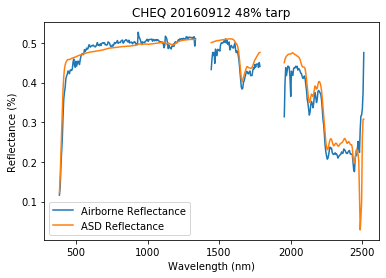

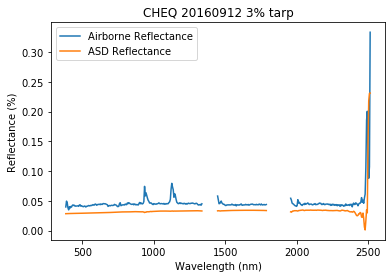

In [13]:
plt.figure(1)
tarp_48_reflectance = np.asarray(reflArray[y_tarp_48_index,x_tarp_48_index,:], dtype=np.float32)/metadata['scaleFactor']
tarp_48_reflectance[index_bad_windows] = np.nan
plt.plot(wavelengths,tarp_48_reflectance,label = 'Airborne Reflectance')
plt.plot(wavelengths,tarp_48_data[:,1], label = 'ASD Reflectance')
plt.title('CHEQ 20160912 48% tarp')
plt.xlabel('Wavelength (nm)'); plt.ylabel('Reflectance (%)')
plt.legend()
#plt.savefig('CHEQ_20160912_48_tarp.png',dpi=300,orientation='landscape',bbox_inches='tight',pad_inches=0.1)

plt.figure(2)
tarp_03_reflectance = np.asarray(reflArray[y_tarp_03_index,x_tarp_03_index,:], dtype=np.float32)/ metadata['scaleFactor']
tarp_03_reflectance[index_bad_windows] = np.nan
plt.plot(wavelengths,tarp_03_reflectance,label = 'Airborne Reflectance')
plt.plot(wavelengths,tarp_03_data[:,1],label = 'ASD Reflectance')
plt.title('CHEQ 20160912 3% tarp')
plt.xlabel('Wavelength (nm)'); plt.ylabel('Reflectance (%)')
plt.legend();
#plt.savefig('CHEQ_20160912_3_tarp.png',dpi=300,orientation='landscape',bbox_inches='tight',pad_inches=0.1)

This produces plots showing the results of the ASD and airborne measurements over the 48% tarp. Visually, the comparison between the two appears to be fairly good. However, over the 3% tarp we appear to be over-estimating the reflectance. Large absolute differences could be associated with ATCOR input parameters (source 4). For example, the user must input the local visibility, which is related to aerosol optical thickness (AOT). We don't measure this at every site, therefore input a standard parameter for all sites. 

Given the 3% reflectance tarp has much lower overall reflectance, it may be more informative to determine what the absolute difference between the two curves are and plot that as well.

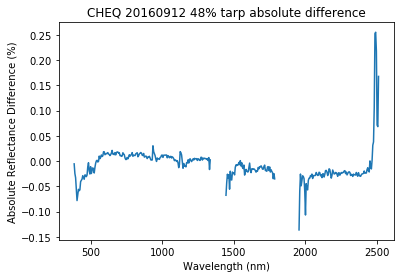

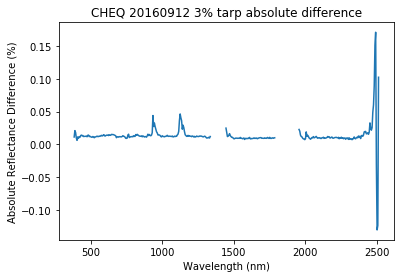

In [14]:
plt.figure(3)
plt.plot(wavelengths,tarp_48_reflectance-tarp_48_data[:,1])
plt.title('CHEQ 20160912 48% tarp absolute difference')
plt.xlabel('Wavelength (nm)'); plt.ylabel('Absolute Reflectance Difference (%)')
#plt.savefig('CHEQ_20160912_48_tarp_absolute_diff.png',dpi=300,orientation='landscape',bbox_inches='tight',pad_inches=0.1)

plt.figure(4)
plt.plot(wavelengths,tarp_03_reflectance-tarp_03_data[:,1])
plt.title('CHEQ 20160912 3% tarp absolute difference')
plt.xlabel('Wavelength (nm)'); plt.ylabel('Absolute Reflectance Difference (%)');
#plt.savefig('CHEQ_20160912_3_tarp_absolute_diff.png',dpi=300,orientation='landscape',bbox_inches='tight',pad_inches=0.1)

From this we are able to see that the 48% tarp actually has larger absolute differences than the 3% tarp. The 48% tarp performs poorly at the shortest and longest wavelenghths as well as near the edges of the bad band windows. This is related to difficulty in calibrating the sensor in these sensitive areas.

Let's now determine the result of the percent difference, which is the metric used by ATCOR to report accuracy. We can do this by calculating the ratio of the absolute difference between curves to the total reflectance 

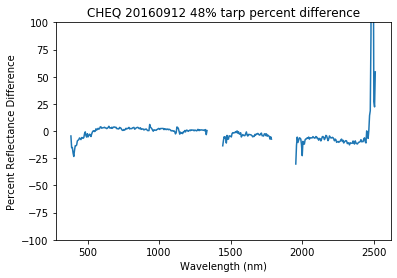

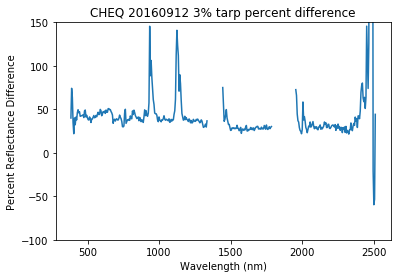

In [15]:
plt.figure(5)
relative_diff_48 = 100*(np.divide(tarp_48_reflectance-tarp_48_data[:,1],tarp_48_data[:,1]))
plt.plot(wavelengths,100*np.divide(tarp_48_reflectance-tarp_48_data[:,1],tarp_48_data[:,1]));
plt.title('CHEQ 20160912 48% tarp percent difference')
plt.xlabel('Wavelength (nm)'); plt.ylabel('Percent Reflectance Difference')
plt.ylim((-100,100))
#plt.savefig('CHEQ_20160912_48_tarp_relative_diff.png',dpi=300,orientation='landscape',bbox_inches='tight',pad_inches=0.1)

plt.figure(6)
plt.plot(wavelengths,100*np.divide(tarp_03_reflectance-tarp_03_data[:,1],tarp_03_data[:,1]));
plt.title('CHEQ 20160912 3% tarp percent difference')
plt.xlabel('Wavelength (nm)'); plt.ylabel('Percent Reflectance Difference')
plt.ylim((-100,150));
#plt.savefig('CHEQ_20160912_3_tarp_relative_diff.png',dpi=300,orientation='landscape',bbox_inches='tight',pad_inches=0.1)



From these plots we can see that even though the absolute error on the 48% tarp was larger, the relative error on the 48% tarp is generally much smaller. The 3% tarp can have errors exceeding 50% for most of the tarp. This indicates that targets with low reflectance values may have higher relative errors.

